In [1]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC

from mlxtend.classifier import StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import plotly.express as px
from matplotlib import pyplot as plt
import scikitplot as skplt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<h1 style="font-size:250%;color:#292F55"> Titanic - Machine Learning from Disaster</h1>

*Top 3% Titanic solution - For this last version best model score is 0.81100*.
![](https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/2-rms-titanic-ship-plans-jose-elias-sofia-pereira.jpg)

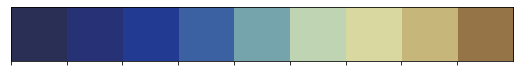

In [2]:
cm = ["#273176","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1"]
gradient = ["#292F55","#273176","#223A92","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1","#C7B679","#957447"]
sns.palplot(gradient)

<a style="font-size:200%;color:#292F55">Table Of Content
* [<a style="font-size:150%;color:#292F55">1. EDA & Feature Engeneering](#1_bullet)
    * [<a style="font-size:130%;color:#3B61A3"> 1.1 Passengers location analisys](#1.1_bullet) - Survival for different Deck / Cabin numbers
    * [<a style="font-size:130%;color:#3B61A3"> 1.2 Groups and family bonds analisys](#1.2_bullet) - Ticket numbers analisys, Names / Surnames
    * [<a style="font-size:130%;color:#3B61A3"> 1.3 Personal features analisys](#1.3_bullet) - Age / Status analisys
* [<a style="font-size:150%;color:#292F55">2. Data preparation](#2_bullet)
    * [<a style="font-size:130%;color:#3B61A3"> 2.1 Filling None values](#2.1_bullet)
    * [<a style="font-size:130%;color:#3B61A3"> 2.2 Encoding features and droping unnecessary](#2.2_bullet)
* [<a style="font-size:150%;color:#292F55">3. Model development](#3_bullet)
    * [<a style="font-size:130%;color:#3B61A3"> 2.1 Catboost baseline](#2.1_bullet)
    


# <a class="anchor" id="1_bullet" style="color:#292F55"> 1. Exploratory Data Analysis (EDA)

In [3]:
path = "/kaggle/input/titanic/"
df_tr = pd.read_csv(f"{path}train.csv").set_index("PassengerId", drop=True)
df_ts = pd.read_csv(f"{path}test.csv").set_index("PassengerId", drop=True)
df = pd.concat([df_tr, df_ts], axis=0)
df.head(10).style.background_gradient(cmap='Blues')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.000000,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
2,1.000000,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1.000000,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
4,1.000000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0.000000,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S
6,0.000000,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
7,0.000000,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
8,0.000000,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,nan,S
9,1.000000,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,nan,S


<AxesSubplot:>

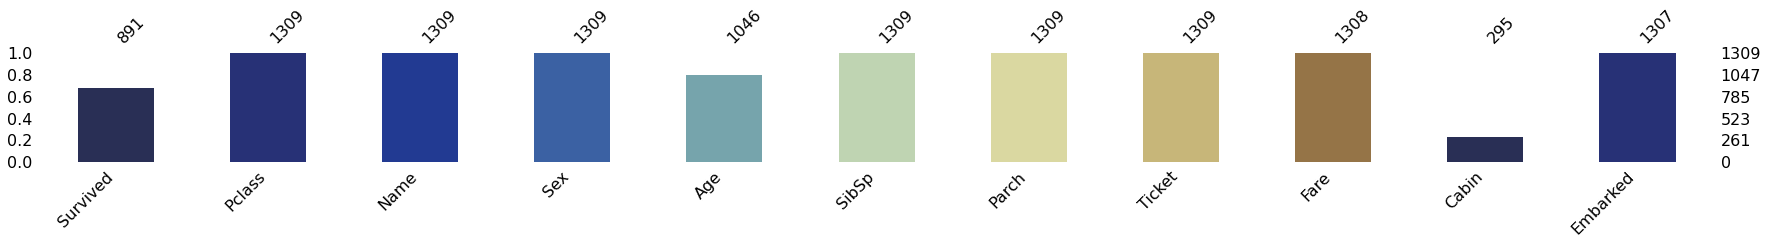

In [4]:
msno.bar(df, figsize=(30,2), color=gradient)

## <a class="anchor" id="1.1_bullet" style="color:#3B61A3"> 1.1 Passengers location analisys 

I assume, that the location of passengers at the moment of the disaster may affect on the surviving rate.

For this case we will try to analyze such location, referring to the time of the disaster - 23:40. It means that some passengers may already have been in their cabins, some of them was hanging on some restaurants and "bars" (linked to there Pclass and maby cabin location) etc.

Anyway, we do not know their location at that moment, but we can create some feature to describe it somehow to help our model.

Offcourse, we have smth like 80% None values in "Cabin" feature - but still some useful information can be extracted + we need to be careful with filling the gaps.

### <a class="anchor" id="1.1.1_bullet" style="color:#3B61A3"> 1.1.1 Survival for different Deck numbers
Deck descriptors are coded inside of the Cabin numbers
We will extract them as a new feature.
Unknowns we will mark as "N/A"

In [5]:
df["Deck"] = df["Cabin"].str[:1]
df["Deck"] = df["Deck"].replace(np.nan,"N/A")
print("All Deck descriptors:")
print(set(df["Deck"].values))

All Deck descriptors:
{'E', 'A', 'T', 'C', 'G', 'N/A', 'D', 'B', 'F'}


In [6]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Deck"]!="N/A"]
fig = px.histogram(dfplt, x="Deck",color="Survived",
                   color_discrete_sequence=cm)
fig.show()

What we can see from such graphs:
*     Only one PassengerId have been on the Deck T - and he is in train set, so we can drop the "T" value
*     There ara some dependancies between surviving rate and the Deck number:

|deck|died|survived|ratio|
|:--:|:--:|:------:|:---:|
|C   |24  |35      |0.4  |
|G   |2   |2       |0.5  |
|D   |8   |25      |0.24 |
|A   |8   |7       |0.53 |
|B   |12  |35      |0.26 |
|F   |5   |8       |0.38 |
|E   |8   |24      |0.25 |
        
In this case - we can put such new features into the model and encode them.

In [7]:
df.loc[df["Deck"]=='T',"Deck"] = 'N/A'

### <a class="anchor" id="1.1.2_bullet" style="color:#3B61A3"> 1.1.2 Cabin numbers analisys
Some of the passangers have shared several cabins - thay may have the same cabin number or leave in 3 of 4 cabins at the same time (families). But actually not only families or reletives shared cabins, but some collegues, friends etc. In this case i will try to create a features, which will describe the location of passangers, linked to there Cabin number.

Some of the cabins has ambiquouse values - i will hardcode them - giving maximum values to multiple cabins 
for a passanger. Or just rename them is several other ways, according to the Deck plans from https://www.encyclopedia-titanica.org/titanic-deckplans/

In [8]:
replaces = {'B51 B53 B55': 'B55', 'B52 B54 B56': 'B56', 'B57 B59 B63 B66': 'B66', 'B58 B60': 'B60', 
            'B82 B84': 'B84', 'B96 B98': 'B98', 'C22 C26': 'C26', 'C23 C25 C27': 'C27', 'C55 C57': 'C57',
            'C62 C64': 'C64', 'D10 D12': 'D12', 'E39 E41': 'E41', 'F E46': 'E46', 'F E57': 'E57',
            'F E69': 'E69', 'F G63': 'G63', 'F G73': 'G73', 'F': None, 'D': None, ' ': None, 'T': None, np.nan: None}
df["Cabin"] = df["Cabin"].replace(replaces)
df["Cabin"] = df.fillna(np.nan)["Cabin"].str[1:].astype(float)

In [9]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Cabin",color="Survived", height=300,
                   color_discrete_sequence=cm)
fig.show()

We can see that there is no accurate dependency between Cabin number and the Survival in general - maby it can work on connection with some other features. Some extra information we can take from the Cabin number - is the Side of the ship (left or right) ,according to the even or odd number of it. The side of the ship can effect much on the serviving rate.

In [10]:
df["Side"] = df["Cabin"]
df.loc[df["Side"]!=0,"Side"] = (df["Cabin"][df["Cabin"]!=0]%2-0.5)*2

s = df[df["Side"]==1]
print(f'Survived for side 1\t {len(s[s["Survived"]==1])/len(s)}')
s = df[df["Side"]==-1]
print(f'Survived for side -1\t {len(s[s["Survived"]==1])/len(s)}')

Survived for side 1	 0.5076923076923077
Survived for side -1	 0.4276729559748428


As we can see - passangers survived more often, living on the 1, then on the side -1

To fill the missing values for "Cabin", we will put median values for all passangers in specific Decks.
Before this, we will devide number of the Cabin by two - because the "side" location has been already taken from the data.
If Deck number is unknown - we will just mark Cabin as -1 - mwaning "Unknown"

In [11]:
for i in set(df["Deck"].values):
    v = df[df["Deck"]==i]["Cabin"]//2
    df.loc[df["Deck"]==i, "Cabin"]= v
    df.loc[(df["Deck"]==i) & (df["Cabin"]==0),"Cabin"] = np.median(v)
    
df.loc[df["Cabin"].isna(),"Cabin"]=-1
df["Cabin"] = df["Cabin"].astype(int)

Now we gonna plot some developed "coordinates" of the passangers, to find some patterns in survival.

In [12]:
dfplt = df.copy(deep=True)
dfplt = dfplt[~dfplt["Survived"].isna()]
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter_3d(dfplt, x="Cabin", y="Side", z= "Deck", color="Survived",
                    color_discrete_sequence=cm, size_max=6, width=1000, height=1000)
fig.show()

We can see some patterns in the data:
  - For example, all of the passangers on the "1" side of the Deck D survived.
  - For only some of decks the "closer" location to zero may cause the better survival (maby those passangers was closer to the ladders)

<AxesSubplot:>

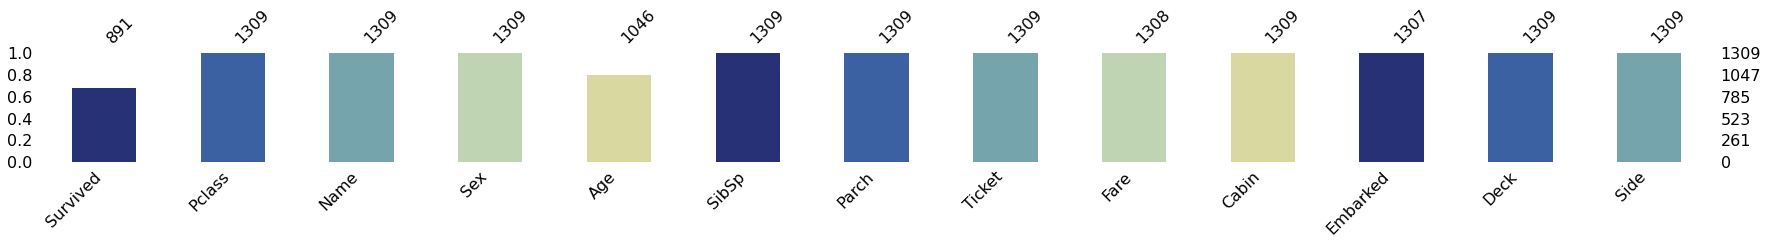

In [13]:
df["Side"] = df["Side"].fillna(0)
msno.bar(df, figsize=(30,2), color=cm)

In the end - we have to fillna for "Side" feature with 0 - refering to unknown side of the ship

## <a class="anchor" id="1.2_bullet" style="color:#3B61A3">  1.2 Groups and family bonds analisys
Some groups of passangers, should be connected via ticket numbers, surnames, classP and etc. We will try to put the data into the shape in which our model will detect such connections
### <a class="anchor" id="1.2.1_bullet" style="color:#3B61A3">  1.2.1 Ticket numbers analisys

**"LINE" tickets:**
All Tickets number contains some numbers, except "LINE" tickets www.encyclopedia-titanica.org
Philadelphia's westbound voyage was cancelled, and several shipmates forced to travel aboard Titanic as passengers (Some of them have LINE ticket number):
 - August Johnson (Johnson, Mr. Alfred) - **LINE** - 370160
 - William Cahoone Jr. Johnson - **LINE** - 370160
 - William Henry Törnquist - **LINE** - 370160
 - Andrew John Shannon (Lionel Leonard) - **LINE** - 370160

We will not analize them much, in this part, but we should take it into account

In [14]:
lin_rep = lambda x: x.replace({'LINE':"370160"})
df = lin_rep(df)

Some of the tickets contains several prefixes refering for some specific sale policies - maby it may be usefull for the model (we will save it into Ticket_p) but at the same time wew will clear our ticket number from umbiques information (It may be some hidden connections in the ticket numbers).

In [15]:
prefixes = []
nums, prefs = [],[]
for i in df["Ticket"].values:   
    if not i.isdigit():
        nums.append(int(re.search('.* {1}([0-9]+)', i).groups()[0]))
        prefix = re.search('(.*)( {1})[0-9]+', i).groups()[0]
        prefs.append(prefix.replace(".","").replace(" ", "").replace("/","")) # Needed to put in one group such prefixes as "A/5", "A/5.", "A.5" etc.
    else:
        nums.append(int(i))
        prefs.append("")
df["Ticket"] = nums
df["Ticket_p"] = prefs

In [16]:
dfplt = df.copy(deep=True)
fig = px.scatter(dfplt.astype(str), x="Ticket_p", y="Name", color= "Survived",
                 color_discrete_sequence=cm, size_max=6,width=1200, height=500)
fig.show()

We can see that some of prefixes appear only one time or only in train dataset. Lets clean them in order not to confuse our model.

We wil do it manualy - couse it is not much off them, and we gonna check them, if maby there is some sintax mistakes.

In [17]:
drop = ["SP", "SOP", "Fa", "SCOW", "PPP", "AS", "CASOTON", "SWPP", "SCAHBasle", "SCA3", "STONOQ", "AQ4", "A2", "LP", "AQ3", ""]
df = df.replace(drop, 'N/A')

In [18]:
dfplt = df.copy(deep=True)
dfplt= dfplt[dfplt["Ticket_p"] != "N/A"]
fig = px.scatter(dfplt.astype(str), x="Ticket_p", y="Name", color= "Survived",
                 color_discrete_sequence=cm, size_max=6,width=1200, height=500)
fig.show()

We do not know much about the meaning of this prefixes, but there are some dependencies:
* No passangers survived with the prefix A4
* Most of the passangers with WC prefix - died

### <a class="anchor" id="1.2.2_bullet" style="color:#3B61A3">  1.2.2 Names, surnames and status feature
To get more information about the family bonds - we will extract surnames instead of Names, and put them into features list/

In [19]:
df[["Surname","Name"]] = [i.split(",") for i in df["Name"].values]

We will get all same-surname groups into one list, to put some feature for it
All others will be marked with "Other".(*)

In [20]:
a = df.groupby("Surname")["Surname"].count()
fam_list = a[a>1].index.values
df.loc[~df["Surname"].isin(fam_list),"Surname"] = "Other"

Lets visualize Surviving rates for families:

In [21]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Surname"]!="Other"]
fig = px.histogram(dfplt, x="Surname",color="Survived",color_discrete_sequence=cm)
fig.show()

The same thing as in (*) we gonna do for those Surnames who do not exist in test set.
Again, i gonna do it manually, cause i dont wanna work with automatization here =)

But just before this we will put some extra feature which mean "Has any namesakes" to determin if the person in som relatio-like group. It may look the same as SibSp, but guess, that som connections between people is hidden.

In [22]:
df["Namesakes"] = 1
df.loc[df["Surname"]=="Other","Namesakes"] = 0

In [23]:
not_imp_s = ["Braund","Allen","Moran","Meyer","Holverson","Turpin","Arnold-Franchi","Panula","Harris","Skoog","Kantor","Petroff","Gustafsson","Zabour",
             "Jussila","Attalah","Baxter","Hickman","Nasser","Futrelle","Navratil","Calic","Bourke","Strom","Backstrom","Ali","Jacobsohn","Larsson",
             "Carter","Lobb","Taussig","Johnson","Abelson","Hart","Graham","Pears","Barbara","O'Brien","Hakkarainen","Van Impe","Flynn","Silvey","Hagland",
             "Morley","Renouf","Stanley","Penasco y Castellana","Webber","Coleff","Yasbeck","Collyer","Thorneycroft","Jensen","Newell","Saad","Thayer","Hoyt",
             "Andrews","Lam","Harper","Nicola-Yarred","Doling","Hamalainen","Beckwith","Mellinger","Bishop","Hippach","Richards","Baclini","Goldenberg",
             "Beane","Duff Gordon","Tylor","Dick","Chambers","Moor","Snyder", "Howard", "Jefferys", "Franklin","Abelseth","Straus","Khalil","Dyker","Stengel",
             "Foley","Buckley","Zakarian","Peacock","Mahon","Clark","Pokrnic","Ware","Gibson","Taylor"]
df = df.replace(not_imp_s,'Other')

In [24]:
df[(df["Surname"]=="Other") & (df["Namesakes"]==True)].head(10).style.background_gradient(cmap="Blues")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Side,Ticket_p,Surname,Namesakes
PassengerId,,,,,,,,,,,,,,,,
1,0.000000,3,Mr. Owen Harris,male,22.000000,1,0,21171,7.250000,-1,S,N/A,0.000000,A5,Other,1
4,1.000000,1,Mrs. Jacques Heath (Lily May Peel),female,35.000000,1,0,113803,53.100000,61,S,C,1.000000,N/A,Other,1
5,0.000000,3,Mr. William Henry,male,35.000000,0,0,373450,8.050000,-1,S,N/A,0.000000,N/A,Other,1
6,0.000000,3,Mr. James,male,nan,0,0,330877,8.458300,-1,Q,N/A,0.000000,N/A,Other,1
9,1.000000,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg),female,27.000000,0,2,347742,11.133300,-1,S,N/A,0.000000,N/A,Other,1
10,1.000000,2,Mrs. Nicholas (Adele Achem),female,14.000000,1,0,237736,30.070800,-1,C,N/A,0.000000,N/A,Other,1
35,0.000000,1,Mr. Edgar Joseph,male,28.000000,1,0,17604,82.170800,-1,C,N/A,0.000000,PC,Other,1
36,0.000000,1,Mr. Alexander Oskar,male,42.000000,1,0,113789,52.000000,-1,S,N/A,0.000000,N/A,Other,1
40,1.000000,3,Miss. Jamila,female,14.000000,1,0,2651,11.241700,-1,C,N/A,0.000000,N/A,Other,1


In [25]:
s = df[df["Namesakes"]==0]
print(f'Have no Namesakes \t {len(s[s["Survived"]==1])/len(s)}')
s = df[df["Namesakes"]==1]
print(f'Have Namesakes \t\t {len(s[s["Survived"]==1])/len(s)}')

Have no Namesakes 	 0.23390894819466249
Have Namesakes 		 0.28720238095238093


In [26]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Surname"]!="Other"]
fig = px.histogram(dfplt, x="Surname",color="Survived",color_discrete_sequence=cm)
fig.show()

Now we will delete all the Families, for which number of Survived equel to not Survived (Again ill do it manually)

In [27]:
drop = ["Abbott","Keane","Minahan","Crosby","Hocking","Dean","Mallet",""]
df = df.replace(drop,'Other')

## <a class="anchor" id="1.3_bullet" style="color:#3B61A3">  1.3 Personal features analisys
### <a class="anchor" id="1.3.1_bullet" style="color:#3B61A3">  1.3.1 Title features
Passangers with different Titles may hav different survival rate (may be connected to so some position on groups, status of inner features)

In [28]:
df["Title"] = pd.DataFrame(df["Name"].str.strip().str.split(".").tolist()).set_index(df.index).iloc[:,0]
df["Title"] = df["Title"].fillna("Others")

In [29]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Title",color="Survived",color_discrete_sequence=cm)
fig.show()

In [30]:
rename = {"Miss":"Ms",
          "Mrs": "Mme",
          "Others": ["Don","Rev","Dr","Lady","Sir","Mlle","Col","the Countess","Mme","Major","Capt","Jonkheer","Dona"]}
for k in rename:
    df["Title"] = df["Title"].replace(rename[k],k)

I desided to delete values with low frequancy - for our model not to be messed up.

In [31]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Title",color="Survived",color_discrete_sequence=cm)
fig.show()

### <a class="anchor" id="1.3.2_bullet" style="color:#3B61A3">  1.3.2 Parch and Age
This features may have crucial effect on the target. Parants was saving there children befor them, and many other connections may be inside of the just two attributes

In [32]:
dfplt = df.copy(deep=True)
dfplt = dfplt[~dfplt["Survived"].isna()]
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Age", y="Parch", color = "Survived", size_max=6
                 ,color_discrete_sequence=cm,width=1200, height=500)
fig.show()

In [33]:
df[(df["Age"]==5) & (df["Parch"]==0)]
# 5 y.o child traveling by hereself?

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Side,Ticket_p,Surname,Namesakes,Title
PassengerId,,,,,,,,,,,,,,,,,
778,1.0,3,Miss. Virginia Ethel,female,5.0,0,0,364516,12.475,-1,S,N/A,0.0,N/A,Other,0,Miss


In the end i desided not to fix it, cause if takes some extra information about the data, and it is kind of cheating.
But i will leave it there just in case someone will need it

In [34]:
#df.loc[df["Name"]=="Emanuel, Miss. Virginia Ethel","Parch"]=1
#df.loc[df["Name"]=="Dowdell, Miss. Elizabeth","Parch"]=1

#df.loc[df["Name"]=="Albimona, Mr. Nassef Cassem","Parch"]=1
#df.loc[df["Name"]=="Hassan, Mr. Houssein G N","Parch"]=1

#df.loc[df["Name"]=='Watt, Mrs. James (Elizabeth "Bessie" Inglis Milne)',"Parch"]=1
#df.loc[df["Name"]=="Watt, Miss. Bertha J","Parch"]=1

We will manually set two more features:
* "Kid" feature - for less then 18 y.o passangers - there survival rate is higher 
* 'Alone' feature - for those who was travalling alone (>18 e.o, Parch & SibSp ==0). 
* 'Old' feature - elder people died more often. I took 60 y.o as a treashold, after checking several and chooseing the one

In [35]:
df["Kid"]=0
df.loc[(df["Age"]<18),"Kid"]=1
print(f'Kids survived koeff:\t{len(df[(df["Kid"]==1) & (df["Survived"]==0)])/len(df[(df["Kid"]==1) & (df["Survived"]==1)])}')
print(f'Others survived koeff:\t{len(df[(df["Kid"]==0) & (df["Survived"]==0)])/len(df[(df["Kid"]==0) & (df["Survived"]==1)])}')

Kids survived koeff:	0.8524590163934426
Others survived koeff:	1.7686832740213523


In [36]:
df["Old"]=0
df.loc[(df["Age"]>60),"Old"]=1
print(f'Elder survived koeff:\t{len(df[(df["Old"]==1) & (df["Survived"]==0)])/len(df[(df["Old"]==1) & (df["Survived"]==1)])}')
print(f'Others survived koeff:\t{len(df[(df["Old"]==0) & (df["Survived"]==0)])/len(df[(df["Old"]==0) & (df["Survived"]==1)])}')

Elder survived koeff:	3.4
Others survived koeff:	1.5786350148367954


In [37]:
df["Alone"] = 0
df.loc[(df["Parch"]==0) & (df["SibSp"]==0),"Alone"]=1
print(f'Alone survived koeff:\t\t{len(df[(df["Alone"]==1) & (df["Survived"]==0)])/len(df[(df["Alone"]==1) & (df["Survived"]==1)])}')
print(f'Not Alone survived koeff:\t{len(df[(df["Alone"]==0) & (df["Survived"]==0)])/len(df[(df["Alone"]==0) & (df["Survived"]==1)])}')

Alone survived koeff:		2.294478527607362
Not Alone survived koeff:	0.9776536312849162


# <a class="anchor" id="2_bullet" style="color:#292F55">  2. Data preparation
## <a class="anchor" id="2.1_bullet" style="color:#3B61A3">  2.1 Filling None values
### <a class="anchor" id="2.1.1_bullet" style="color:#3B61A3">  2.1.1 Filling "Age" None values

<AxesSubplot:>

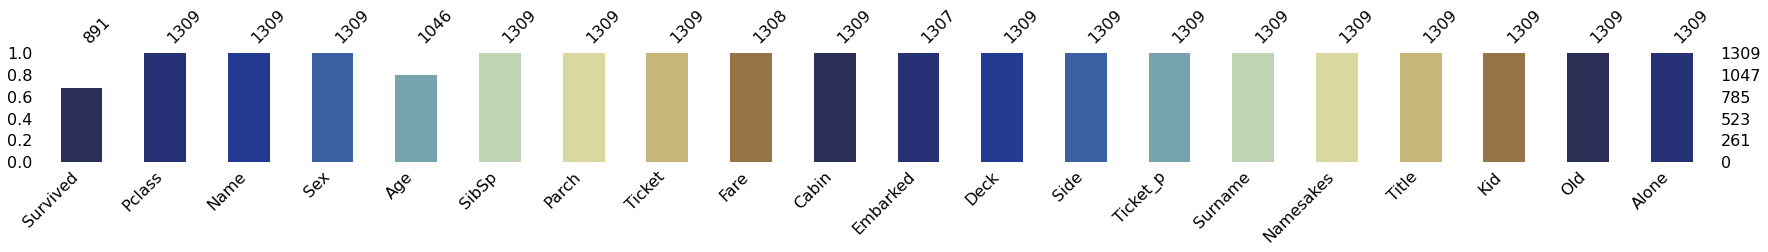

In [38]:
msno.bar(df, figsize=(30,2), color=gradient)

For the "Age" feature we just can replace None values with some mean value, but we gonna do it in a bit more complex way.
We will locate some groups, based on Sex and Pclass - lets check the difference in ages in several groups.

In [39]:
print(df[(df["Pclass"]==1) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==1) & (df["Sex"]=="male")]["Age"].median())
print(df[(df["Pclass"]==2) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==2) & (df["Sex"]=="male")]["Age"].median())
print(df[(df["Pclass"]==3) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==3) & (df["Sex"]=="male")]["Age"].median())

36.0
42.0
28.0
29.5
22.0
25.0


In [40]:
from itertools import *
l1, l2 = [1,2,3], ["female","male"]
for c,s in product(l1,l2):
    msk = (df["Pclass"]==c) & (df["Sex"]==s)
    df.loc[msk,"Age"] = df[msk]["Age"].fillna(df[msk]["Age"].median())

In [41]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Age", y="Name", color = "Survived", size_max=6,
                 width=1200, height=500,color_discrete_sequence=cm)
fig.show()

### <a class="anchor" id="2.1.2_bullet" style="color:#3B61A3">  2.1.2 Filling "Fare" feature
I will manually fill None value with the mean value for passanger class.
After that we can replace Fare with a rank, because i assume that the value of difference is not important.

In [42]:
print(df.loc[1044])
df.loc[1044,"Fare"] = df[df["Pclass"]==3]["Fare"].mean()

Survived             NaN
Pclass                 3
Name          Mr. Thomas
Sex                 male
Age                 60.5
SibSp                  0
Parch                  0
Ticket              3701
Fare                 NaN
Cabin                 -1
Embarked               S
Deck                 N/A
Side                 0.0
Ticket_p             N/A
Surname            Other
Namesakes              0
Title                 Mr
Kid                    0
Old                    1
Alone                  1
Name: 1044, dtype: object


In [43]:
df["Fare"] = df["Fare"].rank(method='max')

In [44]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Fare", y="Name", color = "Survived", size_max=6,
                 width=1200, height=500,color_discrete_sequence=cm)
fig.show()

### <a class="anchor" id="2.1.3_bullet" style="color:#3B61A3">  2.1.3 Filling "Embarked" feature
We have two passangers, whose "Embarked" information is unknown

In [45]:
df[df["Embarked"].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Side,Ticket_p,Surname,Namesakes,Title,Kid,Old,Alone
PassengerId,,,,,,,,,,,,,,,,,,,,
62,1.0,1,Miss. Amelie,female,38.0,0,0,113572,1194.0,14,NaN,B,-1.0,N/A,Other,0,Miss,0,0,1
830,1.0,1,Mrs. George Nelson (Martha Evelyn),female,62.0,0,0,113572,1194.0,14,NaN,B,-1.0,N/A,Other,0,Mrs,0,1,1


According to https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html we can fill nan values with "S"

In [46]:
df.loc[df["Embarked"].isna(),"Embarked"] = "S"

## <a class="anchor" id="2.2_bullet" style="color:#3B61A3">  2.2 Encoding features and droping unnecessary

We can try to apply OneHot encoder for all columns to see how spars will be the matrix

In [47]:
onehot_df = pd.DataFrame(index=df.index)

for c in ["Pclass","Sex","Embarked","Deck","Ticket_p","Surname","Title"]:
    encoded = OneHotEncoder().fit_transform(df[c].to_numpy().reshape(-1,1)).toarray()
    columns = [f"{c}_{i}" for i in range(encoded.shape[1])]
    _df =pd.DataFrame(data=encoded, columns=columns, index=df.index)
    onehot_df = pd.concat([_df,onehot_df], axis=1)
    
onehot_df = pd.concat([onehot_df,df[["Survived","Age","SibSp","Parch","Fare","Cabin","Namesakes","Kid","Alone","Side"]]], axis=1)

for c in ["Age","Fare","Cabin","SibSp","Parch"]:
    onehot_df[c] = MinMaxScaler().fit_transform(onehot_df[c].to_numpy().reshape(-1,1))

In [48]:
onehot_df.head(10).style.background_gradient(cmap="Blues")

Resulting matrix looks like too spars, because of Surnames features, which should provide us some groups of survivals.
Now we gonna try to use it for the baseline. In the next versions, i'll try some other configurations

# <a class="anchor" id="3_bullet" style="color:#292F55">  3. Model development

In [49]:
df_train = onehot_df.copy(deep=True)
mask = df_train["Survived"].isna()
train, deploy = df_train[~mask], df_train[mask]
deploy = deploy.drop("Survived", axis=1)
train.loc[:,"Survived"] = train.loc[:,"Survived"].astype(bool)
x_train, y_train = train.drop("Survived", axis=1), train["Survived"].astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## <a class="anchor" id="3.1_bullet" style="color:#3B61A3">  3.1 Models baselines

We will define the method, which fits the given model and puts all the neccesery data into different structures to use them further:

* deploy_acc  - model accuracy for deploy dataset
* train_acc   - model accuracy after the validation
* models_dict - dictionary of the models


In [50]:
deploy_acc, train_acc, models_dict= {},{},{}

def baseline(name, model, verbose=True):
    models_dict[name] = model
    models_dict[name].fit(x_train,y_train)
    y_train_hat = models_dict[name].predict(x_train)
    train_acc[name] = accuracy_score(y_train,y_train_hat)
    if verbose:
        skplt.metrics.plot_confusion_matrix(y_train, y_train_hat, normalize=True, figsize=(5,5))
    submition = pd.DataFrame(models_dict[name].predict(deploy), index= deploy.index,columns = ["Survived"]).astype(int)
    submition.to_csv(f'{name}.csv')

I've tried several Gridsearches for CVs with Kfold. And after a bunch of deploys, i chose those models.
I chose models which gave me the best deploy accuracy. This models gonna be not "Best model for Survival prediction" , but "The best model to predict the test set", which is not the exect solution for the task.

In [51]:
params = {"penalty":"l2","solver": "liblinear","C":0.2,}
name, model = "lr_baseline", LogisticRegression(**params)
baseline(name, model, verbose=False)

name, model = "svm_baseline", SVC(**{'C': 5, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'})
baseline(name, model, verbose=False)

params = {"eta":0.1,"gamma":0,"max_depth":6,"lambda":0.1,"alpha":10}
name, model = "xg_baseline", XGBClassifier(**params)
baseline(name, model, verbose=False)

params = {"rsm":0.1, "learning_rate":0.005,"iterations":500,"l2_leaf_reg":5,"verbose":False}
name, model = "cb_baseline", CatBoostClassifier(**params)
baseline(name, model, verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[06:08:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


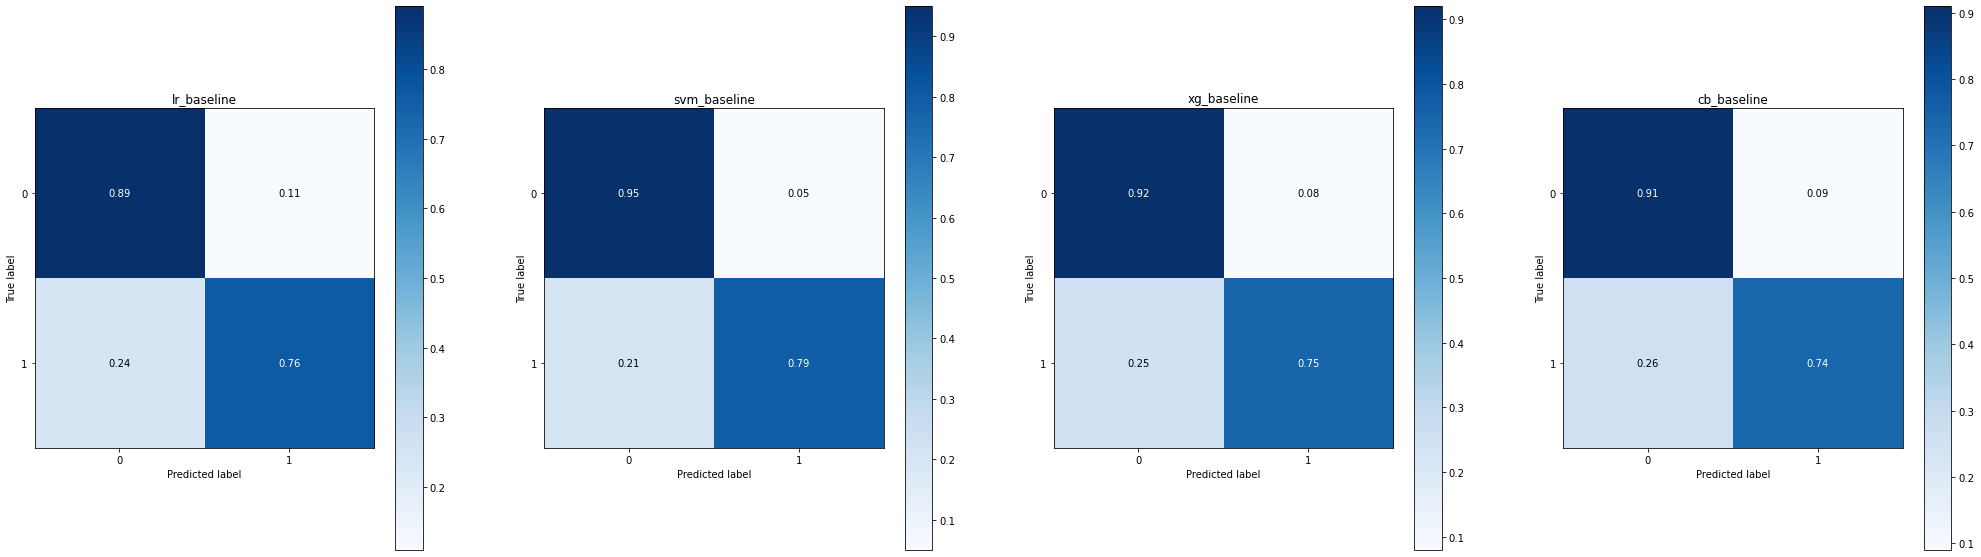

In [52]:
fig = plt.figure(figsize=(35,10))
count=1
for k in models_dict:
    ax = fig.add_subplot(1,len(models_dict),count)
    count+=1
    skplt.metrics.plot_confusion_matrix(y_train, models_dict[k].predict(x_train), normalize=True, figsize=(5,5),ax=ax, cmap="Blues")
    ax.set_title(k)
plt.show()

In [53]:
deploy_acc["lr_baseline"]  = 0.79904
deploy_acc["svm_baseline"] = 0.80382
deploy_acc["xg_baseline"]  = 0.78947
deploy_acc["cb_baseline"]  = 0.79425 
print("Accuracy on the deployment set:")
for k in deploy_acc:
    print(f"{k}\t:\t{deploy_acc[k]}")

Accuracy on the deployment set:
lr_baseline	:	0.79904
svm_baseline	:	0.80382
xg_baseline	:	0.78947
cb_baseline	:	0.79425


In [54]:
print("Accuracy on the training set:")
for k in train_acc:
    print(f"{k}\t:\t{train_acc[k]}")

Accuracy on the training set:
lr_baseline	:	0.8417508417508418
svm_baseline	:	0.8911335578002245
xg_baseline	:	0.8552188552188552
cb_baseline	:	0.8451178451178452


### <a class="anchor" id="3.2_bullet" style="color:#3B61A3"> 3.2 Ensemble models

In [55]:
name, model = "ensemble", StackingClassifier(classifiers=(models_dict["svm_baseline"],models_dict["lr_baseline"],
                                                                    models_dict["xg_baseline"], models_dict["cb_baseline"]),
                                               meta_classifier=LogisticRegression(**{"penalty":"l2","solver": "liblinear","C":0.2,}),
                                               use_features_in_secondary=True)
baseline(name, model, verbose=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[06:08:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
deploy_acc["ensemble"]  = 0.80622

We see, that all 5 models has different sepations on the data (even on the trains set)
Now we gonna combine this models into peculiar ensemble.
We gonna put som waights, according to there deploy results.

In [57]:
ens_train, ens_deploy = {}, {}
for k in models_dict:
    ens_train[k] = models_dict[k].predict(x_train) * deploy_acc[k]
    ens_deploy[k] = models_dict[k].predict(deploy) * deploy_acc[k]
x_train = pd.concat([pd.DataFrame(ens_train, index=x_train.index),x_train], axis=1)        
deploy = pd.concat([pd.DataFrame(ens_deploy, index=deploy.index),deploy], axis=1)

In [58]:
model = SVC()
model.fit(x_train,y_train)
submition = pd.DataFrame({"PassengerId":deploy.index,"Survived":model.predict(deploy)}).astype(int)

In [59]:
submition.to_csv("mixture.csv",index=False) #0.81100

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)